In [1]:
from pyteomics import parser
from pyteomics import fasta
from pathlib import Path
from itertools import combinations

import pandas as pd
import seaborn as sns
import glob
import matplotlib.pyplot as plt

from scipy.spatial.distance import squareform
from scipy.cluster.hierarchy import linkage

import matplotlib.pyplot as plt

In [2]:
# helperfunctions

def get_newick(node, parent_dist, leaf_names, newick='') -> str:
    """
    Convert sciply.cluster.hierarchy.to_tree()-output to Newick format.

    :param node: output of sciply.cluster.hierarchy.to_tree()
    :param parent_dist: output of sciply.cluster.hierarchy.to_tree().dist
    :param leaf_names: list of leaf names
    :param newick: leave empty, this variable is used in recursion.
    :returns: tree in Newick format
    """
    if node.is_leaf():
        return "%s:%.2f%s" % (leaf_names[node.id], parent_dist - node.dist, newick)
    else:
        if len(newick) > 0:
            newick = "):%.2f%s" % (parent_dist - node.dist, newick)
        else:
            newick = ");"
        newick = get_newick(node.get_left(), node.dist, leaf_names, newick=newick)
        newick = get_newick(node.get_right(), node.dist, leaf_names, newick=",%s" % (newick))
        newick = "(%s" % (newick)
        return newick
    
def jaccard_similarity(set1, set2):
    intersection = len(set1 & set2)
    union = len(set1 | set2)
    return intersection / union

def jaccard_distance(proteomes):

    peptide_dict = {}
    for proteome in proteomes:
        peptides = set()
        proteome_name = Path(proteome).stem.split("_")[-1]

        # read the fasta file
        with fasta.read(proteome) as db:
            for entry in db:
                peptides.update(parser.cleave(entry.sequence, parser.expasy_rules['trypsin']))
        peptide_dict[proteome_name] = peptides

    # Compute pairwise Jaccard similarities
    items = list(peptide_dict.keys())
    similarity_matrix = pd.DataFrame(index=items, columns=items)

    for (item1, set1), (item2, set2) in combinations(peptide_dict.items(), 2):
        similarity = jaccard_similarity(set1, set2)
        similarity_matrix.at[item1, item2] = similarity
        similarity_matrix.at[item2, item1] = similarity

    # Fill diagonal with 1s (similarity with itself)
    for item in items:
        similarity_matrix.at[item, item] = 1.0

    # Convert the DataFrame to float
    similarity_matrix = similarity_matrix.astype(float)
    distance_matrix = 1 - similarity_matrix

    return distance_matrix, peptide_dict


def cluster_proteomes(distance_matrix):

    # Convert the square distance matrix to a condensed distance vector
    condensed_distance = squareform(distance_matrix)

    # Perform hierarchical clustering using average linkage
    row_linkage = linkage(condensed_distance, method='average')

    return row_linkage

In [3]:
folder_path_strains = '../data/Fig1_Strain_proteome_coverage/reference_proteomes/strain_proteomes/*.fasta'
folder_phages = '../data/Fig1_Strain_proteome_coverage/reference_proteomes/phage_proteomes/*.fasta'

strain_proteomes = glob.glob(folder_path_strains)

distance_ecoli, peptide_dict = jaccard_distance(strain_proteomes)

distance_ecoli.rename(index={'K12': 'MG1655'}, inplace=True)
distance_ecoli.rename(columns={'K12': 'MG1655'}, inplace=True)

linkage_ecoli = cluster_proteomes(distance_ecoli)

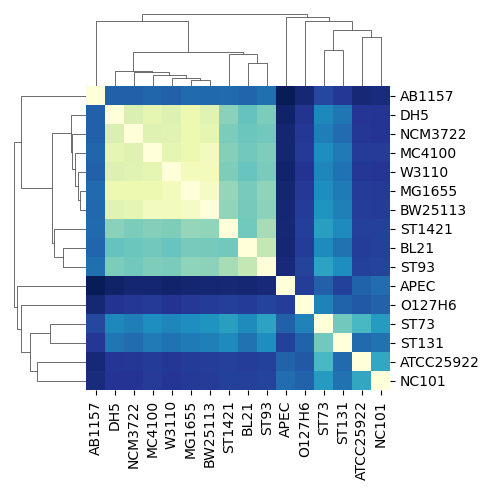

In [4]:
cm = sns.clustermap(distance_ecoli, annot=False, cmap="YlGnBu", cbar=True, figsize=(5, 5), method="average", row_linkage=linkage_ecoli, col_linkage=linkage_ecoli, vmin=0, vmax=0.5)
cm.cax.set_visible(False)

## Are these differences/similarities kept on the identified peptide level?

In [5]:
identified_peptides = pd.read_csv('../data/Fig3D_pairwise_jacquard_similarities/identified_stripped_peptides.tsv', sep  ="\t", usecols=['peptide_sequence'])
identified_peptides = set(identified_peptides['peptide_sequence'])

identified_peptides_dict = {key: value & identified_peptides for key, value in peptide_dict.items()}

peptides_counts = {key: len(value) for key, value in peptide_dict.items()}

# Compute pairwise Jaccard similarities
items = list(identified_peptides_dict.keys())
similarity_matrix_identified = pd.DataFrame(index=items, columns=items)

for (item1, set1), (item2, set2) in combinations(identified_peptides_dict.items(), 2):
    similarity = jaccard_similarity(set1, set2)
    similarity_matrix_identified.at[item1, item2] = similarity
    similarity_matrix_identified.at[item2, item1] = similarity

# Fill diagonal with 1s (similarity with itself)
for item in items:
    similarity_matrix_identified.at[item, item] = 1.0

# Convert the DataFrame to float
similarity_matrix_identified = similarity_matrix_identified.astype(float)
distance_matrix_identified = 1 - similarity_matrix_identified

distance_matrix_identified.rename(columns={'K12': 'MG1655'}, inplace=True)
distance_matrix_identified.rename(index={'K12': 'MG1655'}, inplace=True)


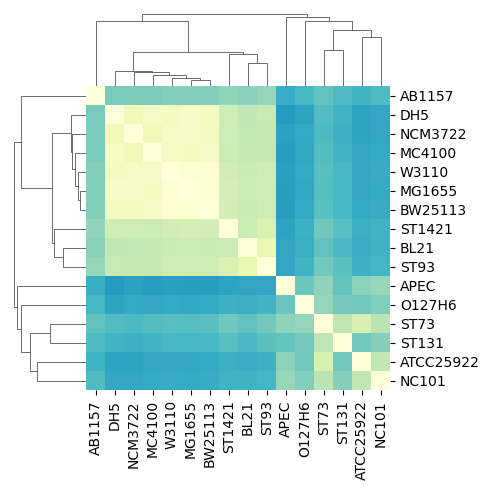

In [6]:
# Plot the heatmap
cm = sns.clustermap(distance_matrix_identified, annot=False, cmap="YlGnBu", cbar=True, figsize=(5, 5), row_linkage=linkage_ecoli, col_linkage=linkage_ecoli, vmin = 0, vmax = 0.5)
cm.cax.set_visible(False)
plt.show()

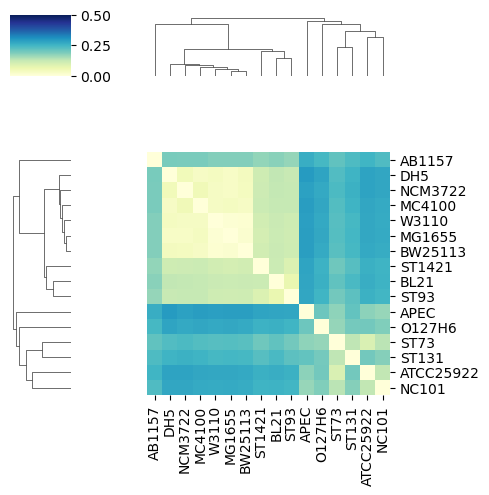

In [7]:
# Get the gradient of the heatmap 
cm = sns.clustermap(distance_matrix_identified, annot=False, cmap="YlGnBu", cbar=True, figsize=(5, 5), row_linkage=linkage_ecoli, col_linkage=linkage_ecoli, vmin = 0, vmax = 0.5)

# add more whitespace between the subplots
plt.subplots_adjust(hspace=0.5, wspace=0.5)
plt.show()